# Image Classification between Butterflies and Bees using Convolutional Neural Networks
Deep learning, a subfield of machine learning that focuses on training data through neural networks with many hidden layers, has many different applications: image classification, speech recognition, handwriting recognition, etc. One of the most known projects in deep learning that utilizes a deep convolutional neural network is the dogs vs. cats image classification example. In this notebook, we apply a basic CNN model, the VGG model, to a dataset of butterflies and bees, and task the program with identifying if a new image is a butterfly or a bee. 

This notebook was created using Machine Learning Mastery's "How to Classify Photos of Dogs and Cats" website as a reference. To view the original code, please see here: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

## Check Current Path
Our butterflies and bees data sets are stored on the Expanse Supercomputer's Lustre File System, so we need to be able access them.

In [1]:
# test
print("hello world")

hello world


In [2]:
import os
!pwd

os.chdir("/expanse/lustre/scratch/jenmar528/temp_project/")
!pwd
!ls

/home/jenmar528
/expanse/lustre/scratch/jenmar528/temp_project
all_imgs	    butterfly_imgs		    other
bee_data	    dataset_butterflies_bees	    testdir
bee_data.csv	    dataset_dogs_vs_cats	    testo
bee_data.zip	    ipykernel_launcher.py_plot.png  testo3_backup
bee_imgs	    kaggle_bee_vs_wasp		    testo6_someimgs
bee_wasp_data.zip   new_bee_imgs_test		    testo_backup
butterfly_data	    newbeeimgs_renamed		    unknown_imgs
butterfly_data.zip  notebook-examples-dev


## Separate into Train and Testing data
Data sets:
* [Butterfly Data Set](https://www.kaggle.com/pnkjgpt/butterfly-classification-dataset)
* [Bee Data Set 1](https://www.kaggle.com/jenny18/honey-bee-annotated-images)
* [Bee Data Set 2](https://www.kaggle.com/jerzydziewierz/bee-vs-wasp)

4479 butterfly images and 5424 bee images were used for a total of 9903 training and testing images. All butterfly images come from the butterfly classification data set. The bee images are made up of images from the "bee1" subfolder of the kaggle_bee_vs_wasp data set as well as with the bee_imgs folder of the annotated honey bee images data set.

All 9903 images are initially located in the all_imgs/ directory and will be randomly moved into train and test folders in the dataset_butterflies_bees overarching directory using the script below. The path file structure will look like the following:

In [ ]:
# path file structure: (do not run; not python code)
dataset_butterflies_bees 
├── test 
│   ├── bees 
│   └── butterflies 
└── train
    ├── bees 
    └── butterflies 

In [3]:
# load dataset, reshape and save to a new file
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import random
import shutil

In [ ]:
# create directories
dataset_home = 'dataset_butterflies_bees/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['butterflies/', 'bees/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		os.makedirs(newdir, exist_ok=True)

In [5]:
# seed random number generator
random.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'all_imgs/'
for file in os.listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random.random() < val_ratio:
		dst_dir = 'test/'
    # all butterfly files are named as butterfly_x with x being some integer number
	if file.startswith('butterfly'):
		dst = dataset_home + dst_dir + 'butterflies/'  + file
		shutil.copyfile(src, dst)
    # all bee files are named as bee_x with x being some integer number
	elif file.startswith('bee'):
		dst = dataset_home + dst_dir + 'bees/'  + file
		shutil.copyfile(src, dst)

## Show test images
Plot out images from each of the different data sets to ensure that they are configured properly.

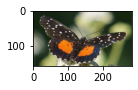

In [4]:
# plot test butterfly photo 
from matplotlib import pyplot as plt
from matplotlib.image import imread

# define location of dataset
folder = 'dataset_butterflies_bees/train/butterflies/'

plt.subplot(330 + 1)
filename = folder + 'butterfly_4006.jpg'
image = imread(filename)
plt.imshow(image)

# show the figure
plt.show()

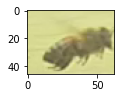

In [5]:
# plot test bee photo from Bee Data Set 1
from matplotlib import pyplot as plt
from matplotlib.image import imread

# define location of dataset
folder = 'dataset_butterflies_bees/train/bees/'

plt.subplot(330 + 1)
filename = folder + 'bee_3560.png'
image = imread(filename)
plt.imshow(image)

# show the figure
plt.show()

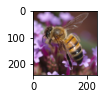

In [6]:
# plot test bee photo from Bee Data Set 2 
from matplotlib import pyplot as plt
from matplotlib.image import imread

# define location of dataset
folder = 'dataset_butterflies_bees/train/bees/'

plt.subplot(330 + 1)
filename = folder + 'bee_5002.jpg'
image = imread(filename)
plt.imshow(image)

# show the figure
plt.show()

## Develop a Baseline CNN Model
The VGG Model architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.

We can explore this architecture on the problem and compare a model with this architecture with 1, 2, and 3 blocks.

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices. For example, a 3-block VGG-style architecture where each block has a single convolutional and pooling layer can be defined in Keras as follows:


block 1 <br>
`model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))` <br>
`model.add(MaxPooling2D((2, 2)))` <br>
block 2 <br>
`model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))`  <br>
`model.add(MaxPooling2D((2, 2)))` <br>
block 3 <br>
`model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))` <br>
`model.add(MaxPooling2D((2, 2)))` <br>


In [35]:
import sys

from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [17]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [18]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	plt.close()

In [19]:
# if image is bugged, do not use it
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [11]:
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_butterflies_bees/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_butterflies_bees/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	print("got past test_it")
		# fit model
	history = model.fit(my_gen(train_it), steps_per_epoch=len(train_it),
		validation_data=my_gen(test_it), validation_steps=len(test_it), epochs=20, verbose=1)
	print("got past history")
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

In [13]:
# entry point, run the test harness
run_test_harness()

Found 7377 images belonging to 2 classes.
Found 2526 images belonging to 2 classes.
got past test_it
Epoch 1/20
116/116 [==============================] - 163s 1s/step - loss: 0.6758 - accuracy: 0.6725 - val_loss: 0.4872 - val_accuracy: 0.7779
Epoch 2/20
116/116 [==============================] - 41s 352ms/step - loss: 0.4496 - accuracy: 0.7850 - val_loss: 0.5555 - val_accuracy: 0.7225
Epoch 3/20
116/116 [==============================] - 41s 352ms/step - loss: 0.3522 - accuracy: 0.8455 - val_loss: 0.3137 - val_accuracy: 0.8717
Epoch 4/20
116/116 [==============================] - 41s 353ms/step - loss: 0.3097 - accuracy: 0.8719 - val_loss: 0.2944 - val_accuracy: 0.8713
Epoch 5/20
116/116 [==============================] - 40s 349ms/step - loss: 0.2648 - accuracy: 0.8906 - val_loss: 0.2551 - val_accuracy: 0.8967
Epoch 6/20
116/116 [==============================] - 41s 355ms/step - loss: 0.2427 - accuracy: 0.9012 - val_loss: 0.2878 - val_accuracy: 0.8816
Epoch 7/20
116/116 [===========

## Two Block VGG Model
The two-block VGG model extends the one block model and adds a second block with 64 filters.

In [20]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [15]:
# The model is fit and evaluated and the performance on the test dataset is reported again
run_test_harness()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Found 7377 images belonging to 2 classes.
Found 2526 images belonging to 2 classes.
got past test_it
Epoch 1/20
116/116 [==============================] - 77s 661ms/step - loss: 0.4968 - accuracy: 0.7651 - val_loss: 0.4067 - val_accuracy: 0.8139
Epoch 2/20
116/116 [==============================] - 75s 649ms/step - loss: 0.3243 - accuracy: 0.8662 - val_loss: 0.2682 - val_accuracy: 0.8963
Epoch 3/20
116/116 [==============================] - 76s 652ms/step - loss: 0.2621 - accuracy: 0.8977 - val_loss: 0.2339 - val_accuracy: 0.9157
Epoch 4/20
116/116 [==============================] - 76s 657ms/step - loss: 0.2156 - accuracy: 0.9188 - val_loss: 0.2082 - val_accuracy: 0.9169
Epoch 5/20
116/116 [==============================] - 75s 649ms/step - loss: 0.2137 - accuracy: 0.9181 - val_loss: 0.2206 - val_accuracy: 0.9188
Epoch 6/20
116/116 [==============================] - 77s 663ms/step - loss: 0.1740 - accuracy: 0.9360 - val_loss: 0.1775 - val_accuracy: 0.9343
Epoch 7/20
116/116 [=========

## Three Block VGG Model
The three-block VGG model extends the two block model and adds a third block with 128 filters.


In [21]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [13]:
# The model is fit and evaluated and the performance on the test dataset is reported again
run_test_harness()

Found 7377 images belonging to 2 classes.
Found 2526 images belonging to 2 classes.
got past test_it
Epoch 1/20
116/116 [==============================] - 221s 2s/step - loss: 0.4767 - accuracy: 0.7691 - val_loss: 0.3109 - val_accuracy: 0.8800
Epoch 2/20
116/116 [==============================] - 96s 824ms/step - loss: 0.3026 - accuracy: 0.8859 - val_loss: 0.2507 - val_accuracy: 0.9046
Epoch 3/20
116/116 [==============================] - 97s 838ms/step - loss: 0.2453 - accuracy: 0.9119 - val_loss: 0.4025 - val_accuracy: 0.8222
Epoch 4/20
116/116 [==============================] - 98s 849ms/step - loss: 0.2313 - accuracy: 0.9134 - val_loss: 0.2257 - val_accuracy: 0.9157
Epoch 5/20
116/116 [==============================] - 97s 832ms/step - loss: 0.1957 - accuracy: 0.9309 - val_loss: 0.1954 - val_accuracy: 0.9276
Epoch 6/20
116/116 [==============================] - 98s 846ms/step - loss: 0.1696 - accuracy: 0.9363 - val_loss: 0.1806 - val_accuracy: 0.9299
Epoch 7/20
116/116 [===========

## Model Improvements
Summary of Results
* VGG 1: 94.220%
* VGG 2: 95.012%
* VGG 3: 95.368%

There is a clear upwards trend with more VGG blocks correlating with higher accurracy rates. However, we also see an increasing trend of overfitting along with the higher accurracy rates. Therefore, we should try to implement some regularization techniques: dropout regularization and data augmentation. These methods will hopefully help reduce overfitting to the data and make generalization to new data improve.

To learn more about the following techiniques, please refer to the resources below.
* [Dropout Regularization in Keras](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/)
* [Image Augmentation with Keras](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)

## Dropout Regularization
Dropout works by probabilistically removing, or “dropping out,” inputs to a layer, which may be input variables in the data sample or activations from a previous layer. It has the effect of simulating a large number of networks with very different network structures and, in turn, making nodes in the network generally more robust to the inputs.

In [33]:
# baseline model with dropout for the dogs vs cats dataset
import sys
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [34]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [35]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	plt.close()

In [36]:
# if image is bugged, do not use it
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [38]:
# define model
model = define_model()

# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterator
train_it = datagen.flow_from_directory('dataset_butterflies_bees/train/',
	class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory('dataset_butterflies_bees/test/',
	class_mode='binary', batch_size=64, target_size=(200, 200))
print("got past test_it")

# fit model
history = model.fit(my_gen(train_it), steps_per_epoch=len(train_it),
	validation_data=my_gen(test_it), validation_steps=len(test_it), epochs=20, verbose=1)

# evaluate model
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

# learning curves
summarize_diagnostics(history)

Found 7377 images belonging to 2 classes.
Found 2526 images belonging to 2 classes.
got past test_it
Epoch 1/20
116/116 [==============================] - 277s 2s/step - loss: 0.6364 - accuracy: 0.6641 - val_loss: 0.5891 - val_accuracy: 0.6738
Epoch 2/20
116/116 [==============================] - 100s 859ms/step - loss: 0.5326 - accuracy: 0.7201 - val_loss: 0.5619 - val_accuracy: 0.7035
Epoch 3/20
116/116 [==============================] - 101s 868ms/step - loss: 0.4545 - accuracy: 0.7796 - val_loss: 0.5736 - val_accuracy: 0.7225
Epoch 4/20
116/116 [==============================] - 102s 879ms/step - loss: 0.4084 - accuracy: 0.8127 - val_loss: 0.5148 - val_accuracy: 0.7395
Epoch 5/20
116/116 [==============================] - 103s 886ms/step - loss: 0.3499 - accuracy: 0.8578 - val_loss: 0.3965 - val_accuracy: 0.8112
Epoch 6/20
116/116 [==============================] - 103s 893ms/step - loss: 0.3116 - accuracy: 0.8734 - val_loss: 0.4216 - val_accuracy: 0.8203
Epoch 7/20
116/116 [======

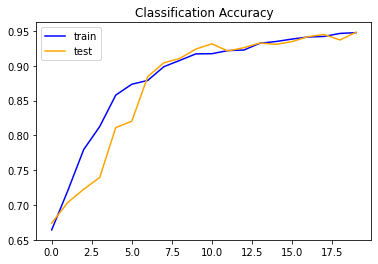

In [39]:
# plot train and val acccuracies
plt.title('Classification Accuracy')
# plt.xlabel('number of epochs')
# plt.ylabel('accuracy (percent)')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.legend()
plt.show()

## Image Data Augmentation
Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

Data augmentation can also act as a regularization technique, adding noise to the training data, and encouraging the model to learn the same features, invariant to their position in the input.

In [7]:
# baseline model with data augmentation for the dogs vs cats dataset
import sys
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
 

In [8]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model
 

In [9]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	plt.close()
 

In [10]:
model = define_model()
# create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
	width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = train_datagen.flow_from_directory('dataset_butterflies_bees/train/',
	class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = test_datagen.flow_from_directory('dataset_butterflies_bees/test/',
	class_mode='binary', batch_size=64, target_size=(200, 200))

# fit model
history = model.fit(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)

# evaluate model
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))


Found 7377 images belonging to 2 classes.
Found 2526 images belonging to 2 classes.
Epoch 1/20
116/116 [==============================] - 360s 3s/step - loss: 0.5311 - accuracy: 0.7454 - val_loss: 0.3516 - val_accuracy: 0.8519
Epoch 2/20
116/116 [==============================] - 98s 838ms/step - loss: 0.3785 - accuracy: 0.8434 - val_loss: 0.2765 - val_accuracy: 0.8994
Epoch 3/20
116/116 [==============================] - 98s 839ms/step - loss: 0.3203 - accuracy: 0.8680 - val_loss: 0.2486 - val_accuracy: 0.9030
Epoch 4/20
116/116 [==============================] - 97s 836ms/step - loss: 0.2912 - accuracy: 0.8841 - val_loss: 0.2179 - val_accuracy: 0.9177
Epoch 5/20
116/116 [==============================] - 98s 843ms/step - loss: 0.2726 - accuracy: 0.8895 - val_loss: 0.2436 - val_accuracy: 0.9066
Epoch 6/20
116/116 [==============================] - 98s 842ms/step - loss: 0.2570 - accuracy: 0.8982 - val_loss: 0.1871 - val_accuracy: 0.9287
Epoch 7/20
116/116 [============================

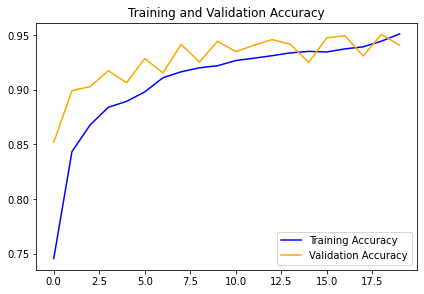

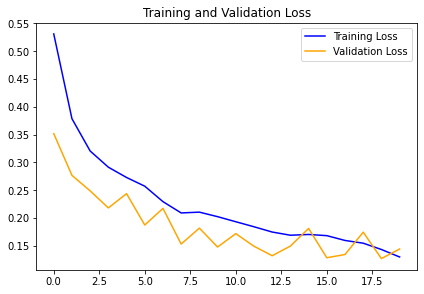

In [14]:
# plot train and val acccuracies
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.title('Training and Validation Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend()
plt.show()

# plot train and val loss
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 2)
plt.title('Training and Validation Loss')
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
plt.legend()
plt.show()

# Make Predictions


In [39]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np

In [42]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model
model = define_model()

In [ ]:
pred = model.predict(test_it)

In [46]:
ans = model.evaluate(test_it)

40/40 [==============================] - 10s 259ms/step - loss: 0.1522 - accuracy: 0.9477
